In [1]:
pip install -q tensorflow tensorflow-datasets

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
tfds.disable_progress_bar()

In [3]:
builder = tfds.builder('rock_paper_scissors')
info = builder.info
print(info)

tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    full_name='rock_paper_scissors/3.0.0',
    description="""
    Images of hands playing rock, paper, scissor game.
    """,
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    data_path='~/tensorflow_datasets/rock_paper_scissors/3.0.0',
    file_format=tfrecord,
    download_size=219.53 MiB,
    dataset_size=Unknown size,
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=372, num_shards=1>,
        'train': <SplitInfo num_examples=2520, num_shards=2>,
    },
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock-paper-scissors-dataset"
    

In [4]:
ds_train = tfds.load(name="rock_paper_scissors", split='train')
ds_test = tfds.load(name="rock_paper_scissors", split='test')

Dataset rock_paper_scissors downloaded and prepared to ~/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.


The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`


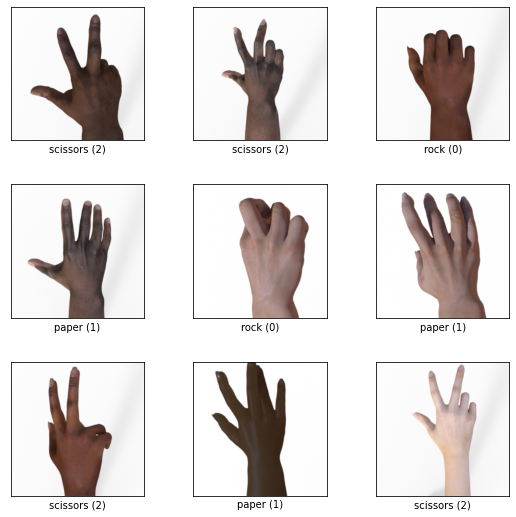

In [5]:
fig = tfds.show_examples(info, ds_train)

In [6]:
train_images = np.array([example['image'].numpy() for example in ds_train])
test_images = np.array([example['image'].numpy() for example in ds_test])
print(train_images.shape)
print(test_images.shape)

(2520, 300, 300, 3)
(372, 300, 300, 3)


In [7]:
train_images = np.array([example['image'].numpy()[:,:,0] for example in ds_train])
test_images = np.array([example['image'].numpy()[:,:,0] for example in ds_test])
print(train_images.shape)
print(test_images.shape)

(2520, 300, 300)
(372, 300, 300)


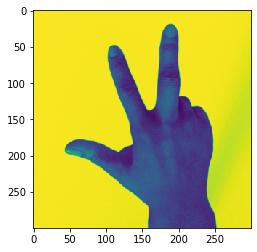

In [8]:
plt.imshow(train_images[0], interpolation='nearest')
plt.show()

In [9]:
train_labels = np.array([example['label'].numpy() for example in ds_train])
test_labels = np.array([example['label'] for example in ds_test])
print(len(train_labels))
print(len(test_labels))

2520
372


In [11]:
train_images = train_images.reshape(2520, 300, 300, 1)
test_images = test_images.reshape(372, 300, 300, 1)

In [12]:
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')
train_images /= 255
test_images /= 255

In [14]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils

In [15]:
model = keras.Sequential([
   keras.layers.AveragePooling2D(6,3, input_shape=(300,300,1)),
   keras.layers.Conv2D(64, 3, activation='relu'),
   keras.layers.Conv2D(32, 3, activation='relu'),
   keras.layers.MaxPool2D(pool_size=(6,6)),
   keras.layers.Dropout(0.35),
   keras.layers.Flatten(),
   keras.layers.Dense(128, activation='sigmoid'),
   keras.layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.fit(train_images, train_labels, epochs=7, batch_size=32)

Epoch 1/7
79/79 [==============================] - 10s 29ms/step - loss: 0.7391 - accuracy: 0.6972
Epoch 2/7
79/79 [==============================] - 2s 26ms/step - loss: 0.1875 - accuracy: 0.9532
Epoch 3/7
79/79 [==============================] - 2s 27ms/step - loss: 0.0675 - accuracy: 0.9845
Epoch 4/7
79/79 [==============================] - 2s 28ms/step - loss: 0.0350 - accuracy: 0.9937
Epoch 5/7
79/79 [==============================] - 2s 26ms/step - loss: 0.0198 - accuracy: 0.9952
Epoch 6/7
79/79 [==============================] - 2s 26ms/step - loss: 0.0137 - accuracy: 0.9972
Epoch 7/7
79/79 [==============================] - 2s 26ms/step - loss: 0.0091 - accuracy: 0.9984


In [16]:
model.evaluate(test_images, test_labels)

12/12 [==============================] - 0s 28ms/step - loss: 0.5557 - accuracy: 0.8145


[0.5557003021240234, 0.8145161271095276]

In [18]:
import keras_tuner
from tensorflow import keras

In [19]:
def cnn_model(hp):
  model = keras.Sequential()
  model.add(keras.layers.AveragePooling2D(6,3, input_shape=(300,300,1)))
  model.add(keras.layers.Conv2D(64, 3, activation='relu'))
  model.add(keras.layers.Conv2D(32, 3, activation='relu'))
  my_pooling_size = hp.Int("pooling_size", min_value=4, max_value=7, step=1)
  model.add(keras.layers.MaxPool2D(pool_size=(my_pooling_size, my_pooling_size)))
  my_dropout_rate = hp.Float("dropout_rate", min_value=0.2, max_value=0.4, step=0.05)
  model.add(keras.layers.Dropout(my_dropout_rate))
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(128, activation=hp.Choice("activation", ["relu","sigmoid","tanh"])))
  model.add(keras.layers.Dense(3, activation='softmax'))
  model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
  return model

tuner = keras_tuner.RandomSearch(
    hypermodel=cnn_model,
    objective="val_accuracy",
    max_trials=10
)

tuner.search(train_images, train_labels, validation_data=(test_images, test_labels), epochs=8, batch_size=32)

Trial 10 Complete [00h 00m 20s]
val_accuracy: 0.8198924660682678

Best val_accuracy So Far: 0.8602150678634644
Total elapsed time: 00h 03m 28s


In [20]:
models = tuner.get_best_models()
best_model = models[0]
best_model.evaluate(test_images, test_labels)

12/12 [==============================] - 0s 17ms/step - loss: 0.3919 - accuracy: 0.8602


[0.39194151759147644, 0.8602150678634644]

In [29]:
from sklearn.metrics import confusion_matrix, classification_report

prediction = np.argmax(best_model.predict(test_images), axis=1)
cm = confusion_matrix(test_labels, prediction, labels=[0,1,2])
clr = classification_report(test_labels, prediction, labels=[0,1,2], target_names=['Rock','Paper','Scissors'])
cm

12/12 [==============================] - 0s 14ms/step


array([[106,   4,  14],
       [  0, 118,   6],
       [ 15,  13,  96]])

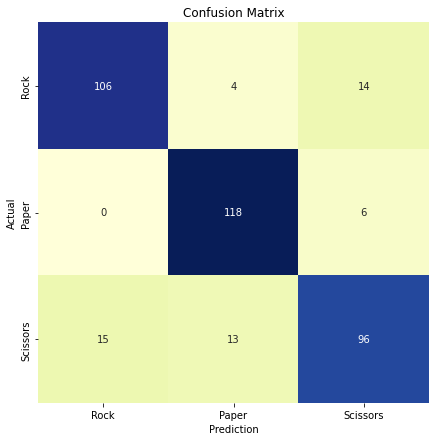

Classification Report:
---------------
               precision    recall  f1-score   support

        Rock       0.88      0.85      0.87       124
       Paper       0.87      0.95      0.91       124
    Scissors       0.83      0.77      0.80       124

    accuracy                           0.86       372
   macro avg       0.86      0.86      0.86       372
weighted avg       0.86      0.86      0.86       372



In [37]:
import seaborn as sns
plt.figure(figsize=(7,7))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='YlGnBu', cbar=False)
plt.xticks(ticks=[0.5, 1.5, 2.5], labels=['Rock','Paper','Scissors'])
plt.yticks(ticks=[0.5, 1.5, 2.5], labels=['Rock','Paper','Scissors'])
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
print('Classification Report:\n---------------\n',clr)

The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`


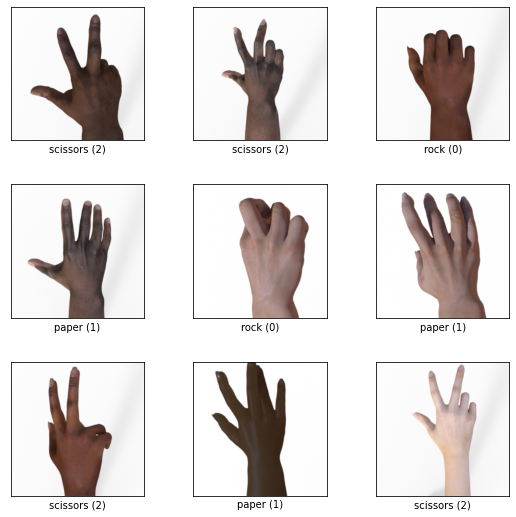

In [38]:
fig = tfds.show_examples(info, ds_train)

In [ ]:
from tensorflow.keras import layers
ds_train = tfds.load(name="rock_paper_scissors", split='train')
ds_test = tfds.load(name="rock_paper_scissors", split='test')
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal")
])

aug_ds = ds_train.map(
  lambda x, y: (data_augmentation(x, training=True),y))